## Импорты

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm_notebook, trange
import pickle
import numpy as np
from IPython.display import clear_output

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
device

device(type='cuda', index=0)

In [0]:
!pip install telepyth -q

from telepyth import TelepythClient

tp = TelepythClient("14890519403566776828")

# Предобработка

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_path = '/content/drive/My Drive/vkr'
# code_batched = base_path + '/after_preprocess/after_preprocess.part0'

In [0]:
def build_vocab():
    # load pre-computed vocab
    with open(base_path + '/mapping.map', 'rb') as f:
#         print(base_path + '/mapping.map')
        word_to_id = pickle.load(f)
    id_to_word = dict([(v, k) for (k, v) in word_to_id.items()])
    return word_to_id, id_to_word

word_to_id, id_to_word = build_vocab()


In [0]:

params = {
    'batch_size': 128,
    'emb_size': 150,
    'vocab_size': len(word_to_id),
    # 'seq_len': 100,
}


In [0]:
# def get_code_data(path):
#     for _, _, files in os.walk(path):
#         data = np.empty((0, 100))
#         for file in tqdm_notebook(files):
#             with open(path + file, 'rb') as f:
#                 array = pickle.load(f)
#                 for i in tqdm_notebook(range(len(array)), leave=False):
#                     data = np.concatenate((data, array[i].inputs), axis=0)
#     return data


In [0]:
# data = get_code_data(base_path + '/after_preprocess/')

In [0]:
# with open('./after_preprocess/all_inputs', 'wb') as f:
#     pickle.dump(data.astype('int64'), f)

In [0]:
# with open(data_path, 'rb') as f:
#     bla = pickle.load(f)
# len(bla)

In [0]:
data_path = base_path + '/after_preprocess/all_inputs'

In [0]:
# split threshold for train/test
# approximately data contains 700k object
split_num = int(700000 * 0.7)

In [0]:
class CodeDataset(Dataset):
    def __init__(self, path, params, start, end):
        with open(path, 'rb') as f:
            self.data = pickle.load(f)[start:end]

    def __len__(self):
#         return 10
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index]


In [0]:
train_loader = DataLoader(
    CodeDataset(data_path, params, 0, split_num),
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=10
)

In [0]:
test_loader = DataLoader(
    CodeDataset(data_path, params, split_num, None),
    batch_size=params['batch_size'],
    shuffle=True,
    num_workers=10
)

# Инициализация модели

In [0]:
class LstmBaseline(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.embedding = nn.Embedding(
            self.params['vocab_size'],
            self.params['emb_size']
        )
        self.lstm = nn.LSTM(
            self.params['emb_size'],
            self.params['emb_size'],
#             2
            1
        )
        self.linear = nn.Linear(
            self.params['emb_size'],
            self.params['vocab_size']
        )
    
    def init_hidden(self, batch_size):
        pass

    def forward(self, inputs, hidden):
        embs = self.embedding(inputs)
        # need 100, 64, 150(?)
        # real 64, 100, 150
        output, hidden = self.lstm.forward(embs, hidden)
        output = self.linear(output)
        return output, hidden


# Обучение

In [0]:
def train_epoch(model, optimizer, lr):
    loss_log = []
    model.train()
    total = 0
    correct = 0
    
    for batch_num, x in zip(trange(len(train_loader)), train_loader):
        optimizer.zero_grad()
        x = x.to(device)
        loss_value = 0.
        loss = nn.CrossEntropyLoss()
        # todo check
        hidden = None
        for i in range(x.shape[1] - 1):
            output, hidden = model.forward(x[:, i].unsqueeze(1), hidden)
            loss_value += loss(output.squeeze(1), x[:, i + 1])
            
            _, arg_pred = torch.max(output.squeeze(1), 1)
            eq_arr = arg_pred == x[:, i + 1]
            total += eq_arr.shape[0]
            correct += int(eq_arr.sum())
        loss_value.backward()

#         torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
#         for p in model.parameters():
#             p.data.add_(-lr, p.grad.data)
        optimizer.step()
        loss_value = loss_value.item()
        loss_log.append(loss_value)# / x.shape[1])

    accuracy = correct / total
    return accuracy, loss_log

def test(model):
    loss_log = []
    model.eval()
    total = 0
    correct = 0
    for batch_num, x in zip(trange(len(test_loader)), test_loader):
        x = x.to(device)
        loss_value = 0.
        hidden = None
        for i in range(x.shape[1] - 1):
            output, hidden = model.forward(x[:, i].unsqueeze(1), hidden)
            _, arg_pred = torch.max(output.squeeze(1), 1)
            eq_arr = arg_pred == x[:, i + 1]
            total += eq_arr.shape[0]
            correct += int(eq_arr.sum())
    accuracy = correct / total
    return accuracy

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    acc_log = []
    lr = 0.05
    lr_decay_base = 1 / 1.15
    m_flat_lr = 20.0
    for epoch in range(n_epochs):
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
        accuracy, train_loss = train_epoch(model, opt, lr)
        train_log.extend(train_loss)
        acc_log.append(accuracy)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': train_log[-1]
            },
            base_path + '/model_checkpoints2/lstm_baseline_checkpoint_{}.pt'.format(epoch)
        )
        clear_output()
        print("Epoch:{}".format(epoch))
        print("Accuracy:", accuracy)
        tp.send_text('Epoch {}, LSTM baseline accuracy: {}'.format(epoch, accuracy))
        plot_history(train_log)
#     np.save("/home/.../model_checkpoints..._logs.npy", np.array(train_log))
#     np.save("/home/.../model_checkpoints..._logs_perp.npy", np.array(perp_log))


In [0]:
model = LstmBaseline(params).to(device)

Epoch:1
Accuracy: 0.35851835690202705


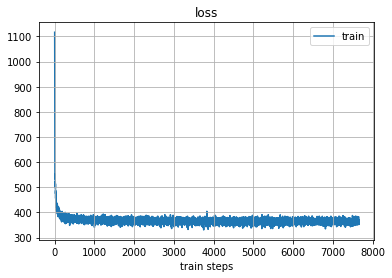

  7%|▋         | 254/3829 [05:57<1:23:40,  1.40s/it]

KeyboardInterrupt: ignored

In [20]:
%%time

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model, optimizer, 5)

In [22]:
%%time

print('Accuracy:', test(model))

100%|██████████| 1607/1607 [16:32<00:00,  1.65it/s]
Accuracy: 0.3440257559846452
CPU times: user 11min 24s, sys: 5min 3s, total: 16min 27s
Wall time: 16min 32s
